In [1]:
import numpy as np
import torch

from fastai.vision.all import *
from fastlabel import labelling_tool
from dextr.model import DextrModel

In [139]:
x = torch.rand(1,3,8,8)

In [140]:
conv = nn.Conv2d(3,6,kernel_size=3,stride=2, padding=1, bias=False)

In [161]:
def ops(conv, x):
    "compute operations of conv over x"
    h,w = x.shape[2:]
    in_channels = conv.in_channels
    out_channels = conv.out_channels
    kernel_size = conv.kernel_size
    bias = conv.bias
    stride = conv.stride
    padding = conv.padding
    y_ops = (h - kernel_size[0] + 2*padding[0]+1)//stride[0]
    x_ops = (w - kernel_size[1] + 2*padding[1]+1)//stride[1]
    print(f'{y_ops=},{x_ops=}')
    total_kernel_pass = x_ops * y_ops
    mults = in_channels*out_channels*x_ops*y_ops*kernel_size[0]*kernel_size[1]
    sums =  in_channels*out_channels*x_ops*y_ops*(kernel_size[0]*kernel_size[1]-1) + len(ifnone(bias, []))*(x_ops*y_ops)
    return mults, sums

In [162]:
out = conv(x)
out.shape

torch.Size([1, 6, 2, 2])

In [163]:
3*3*4*3*6

648

In [164]:
ops(conv, x)

y_ops=2,x_ops=2


(648, 576)

In [165]:
x = torch.rand(1,3,4,4)
conv = nn.Conv2d(3,6,kernel_size=3,stride=2, padding=1, bias=False)
out = conv(x)
ops(conv, x)

y_ops=2,x_ops=2


(648, 576)

In [166]:
conv2 = nn.Conv2d(6,6,kernel_size=3,stride=1,padding=1, bias=False)
ops(conv2, out)

y_ops=2,x_ops=2


(1296, 1152)

In [167]:
from nbdev.showdoc import show_doc

In [168]:
show_doc(Learner.validate)

<h4 id="Learner.validate" class="doc_header"><code>Learner.validate</code><a href="https://github.com/fastai/fastai/tree/master/fastai/learner.py#L217" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.validate</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`cbs`**=*`None`*)

Validate on `dl` with potential new `cbs`.

In [13]:
image_paths = Path.cwd().parent/'images'

image_paths = [f for f in image_paths.ls() if f.suffix == '.jpg']

In [42]:
labelled_images = labelling_tool.PersistentLabelledImage.for_files(image_paths, labels_dir=None, readonly=True)

In [43]:
labelled_images

In [44]:
from dextr.model import DextrModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dextr_model = DextrModel.pascalvoc_resunet101().to(device)

dextr_model.eval()

dextr_fn = lambda image, points: dextr_model.predict([image], points[None, :, :])[0] >= 0.5

In [46]:
image = labelled_images[0]

In [51]:
pixels = image.read_pixels()
pixels.shape

(612, 816, 3)

<AxesSubplot:>

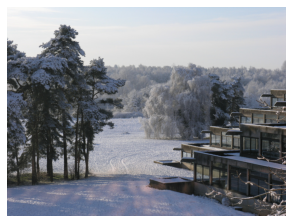

In [50]:
show_image(pixels)

In [71]:
dextr_points = np.array([[50,0], [500,0], [500,300], [200,400]])

In [175]:
inv_points = [p[::-1] for p in dextr_points]

In [176]:
points = TensorPoint.create(inv_points)

In [187]:
mask = dextr_fn(pixels, dextr_points)
mask.shape

(612, 816)

<AxesSubplot:>

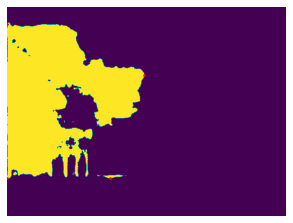

In [178]:
ctx = show_image(mask)
points.show(ctx=ctx)

## Understanding Predict

In [179]:
from dextr.data_pipeline import dextr_transforms
from dextr.model import _DextrInferenceDataset
from skimage.util import img_as_ubyte, img_as_float32

In [180]:
target_size_yx = dextr_model.target_size_yx
padding = dextr_model.padding
blob_sigma = dextr_model.blob_sigma
net = dextr_model.net

In [181]:
from torchvision.transforms import Compose
inference_transforms = Compose([
            dextr_transforms.DextrCropWithHeatmapTransform(
                target_size_yx=target_size_yx,
                padding=padding,
                blob_sigma=blob_sigma,
            ),
            dextr_transforms.DextrToTensor(),
            dextr_transforms.DextrNormalize(),
        ])

In [182]:
images = [pixels]
object_extreme_points = dextr_points[None, :, :]

In [183]:
ds = _DextrInferenceDataset(images, object_extreme_points, transform=inference_transforms)
loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 4, 512, 512])


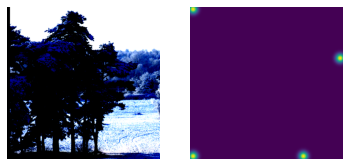

In [184]:
for im in loader:
    image = im['input']
    print(image.shape)
    show_images([image[0,0:3], image[0,3]])

In [129]:
sample_i = 0
predictions = []
with torch.no_grad():
    for batch in loader:
        input = batch['input']
        crop_yx = batch['crop_yx'].detach().cpu().numpy()

        pred_logits = net(input)['out']

        pred_prob = torch.sigmoid(pred_logits).detach().cpu().numpy()

        for i in range(len(crop_yx)):
            image_size = ds.image_sizes[sample_i]
            pred_pil = dextr_transforms.paste_mask_into_image(
                image_size, pred_prob[i, 0, :, :], crop_yx[i])

            pred_pil_arr = img_as_float32(np.array(pred_pil))

            predictions.append(pred_pil_arr)

            sample_i += 1

<AxesSubplot:>

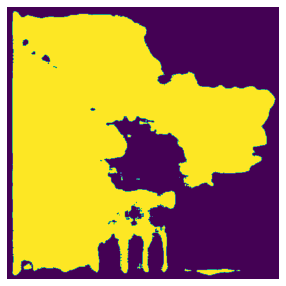

In [139]:
show_image(pred_prob[0,0]>0.5)

In [55]:
regions = labelling_tool.PolygonLabel.mask_image_to_regions_cv(mask, sort_decreasing_area=True)
regions_js = labelling_tool.PolygonLabel.regions_to_json(regions)
regions_js

[[{'x': 0.0, 'y': 0.0},
  {'x': 1.0, 'y': 92.0},
  {'x': 1.0, 'y': 96.0},
  {'x': 1.0, 'y': 91.0},
  {'x': 2.0, 'y': 89.0},
  {'x': 4.0, 'y': 87.0},
  {'x': 7.0, 'y': 89.0},
  {'x': 9.0, 'y': 90.0},
  {'x': 11.0, 'y': 91.0},
  {'x': 12.0, 'y': 89.0},
  {'x': 14.0, 'y': 89.0},
  {'x': 17.0, 'y': 86.0},
  {'x': 19.0, 'y': 84.0},
  {'x': 20.0, 'y': 81.0},
  {'x': 23.0, 'y': 79.0},
  {'x': 25.0, 'y': 82.0},
  {'x': 25.0, 'y': 87.0},
  {'x': 28.0, 'y': 90.0},
  {'x': 28.0, 'y': 93.0},
  {'x': 29.0, 'y': 91.0},
  {'x': 31.0, 'y': 90.0},
  {'x': 32.0, 'y': 88.0},
  {'x': 34.0, 'y': 88.0},
  {'x': 36.0, 'y': 90.0},
  {'x': 37.0, 'y': 87.0},
  {'x': 39.0, 'y': 85.0},
  {'x': 41.0, 'y': 84.0},
  {'x': 44.0, 'y': 83.0},
  {'x': 44.0, 'y': 81.0},
  {'x': 43.0, 'y': 77.0},
  {'x': 44.0, 'y': 75.0},
  {'x': 46.0, 'y': 72.0},
  {'x': 47.0, 'y': 69.0},
  {'x': 44.0, 'y': 67.0},
  {'x': 43.0, 'y': 64.0},
  {'x': 47.0, 'y': 62.0},
  {'x': 51.0, 'y': 59.0},
  {'x': 51.0, 'y': 61.0},
  {'x': 54.0, 'y': 61